# Exploring Charades-STA

TODO

- Check duration stats
- Generate a JSON
    - list of dicts
    - each dict represents as instance
    - _Fields_: check code for `didemo.py`

In [1]:
def parse_charades_sta(filename):
    "Parser of charades-STA annotations"
    instances = []
    with open(filename, 'r') as fid:
        for line in fid:
            line = line.strip()
            video_info, description = line.split('##')
            video_id, t_start, t_end = video_info.split()
            t_start = float(t_start)
            t_end = float(t_end)
            
            instances.append(
                {'video': video_id,
                 'segments': [[t_start, t_end]],
                 'description': description}
            )
            # print(video, t_start, t_end, description)
    return instances

## 1. Moments duration analysis in the dataset

Why? to extend SMCN and all its variants, we need to do the dirty work done by DiDeMo setup.

> DiDeMo makes it easy by defining the search space up front.

What? We need to set a couple of parameters: (i) _minimum_ moment length, (ii) _maximum_ moment length, (iii) _type of range_, how to explore minimum -> maximum, and (iv) _striding_ to reduce the search space.

Negative durations:  4
Negative durations:  0


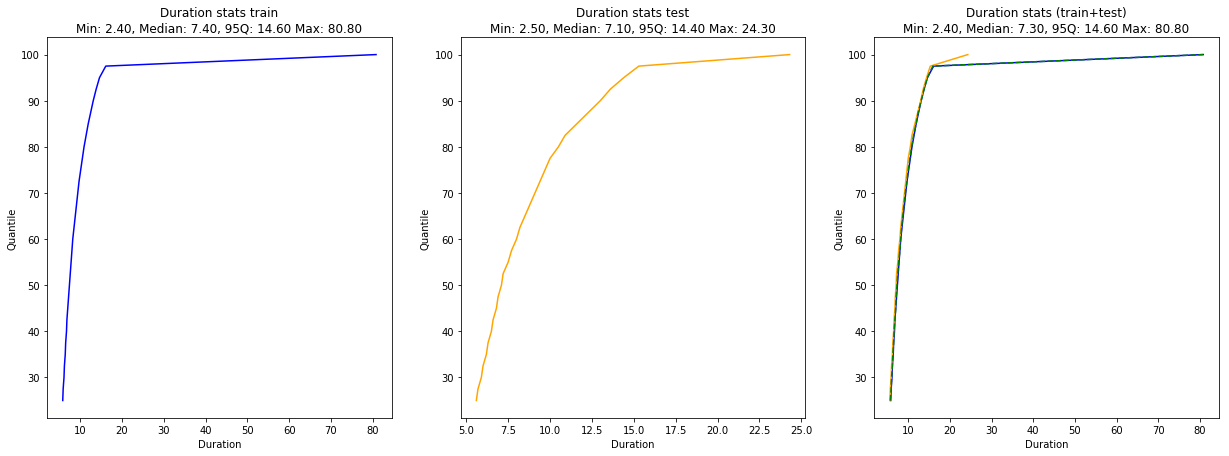

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Q = 95
QUANTILES = np.arange(25, 101, 2.5)
COLOR = ['blue', 'orange', 'green']

all_duration = []
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
for i, subset in enumerate(['train', 'test']):
    filename = f'../data/raw/charades/charades_sta_{subset}.txt'
    data = parse_charades_sta(filename)
    duration = [i['segments'][0][1] - i['segments'][0][0]
                for i in data]
    all_duration += duration
    
    duration = np.array(duration)
    print('Negative durations: ', sum(duration < 0))
    percentiles = np.percentile(duration, QUANTILES)
    axs[i].plot(percentiles, QUANTILES, color=COLOR[i])
    axs[-1].plot(percentiles, QUANTILES, color=COLOR[i])
    axs[i].set_xlabel('Duration')
    axs[i].set_ylabel('Quantile')
    axs[i].set_title(f'Duration stats {subset}\n'
                     f'Min: {np.min(duration[duration > 0]):.2f}, '
                     f'Median: {np.median(duration):.2f}, '
                     f'{Q}Q: {percentiles[QUANTILES == Q][0]:.2f} '
                     f'Max: {np.max(duration):.2f}')
duration = np.array(all_duration)
percentiles = np.percentile(duration, QUANTILES)
axs[-1].plot(percentiles, QUANTILES, ls='--', color=COLOR[-1])
axs[-1].set_xlabel('Duration')
axs[-1].set_ylabel('Quantile')
_ = axs[-1].set_title('Duration stats (train+test)\n'
                      f'Min: {np.min(duration[duration > 0]):.2f}, '
                      f'Median: {np.median(duration):.2f}, '
                      f'{Q}Q: {percentiles[QUANTILES == Q][0]:.2f} '
                      f'Max: {np.max(duration):.2f}')

- Minimum length of a moment or chunk size.

  The initial batch of experiments will be done with 3s as there are psicological references that support that number and it's close to the minimum.

  _considerations that will go to the Appendix_
  
  We can pick the minimum or probably something around
  
  a. $\text{min} ( \text{duration} ) (1 + \text{tIOU}_\text{ref})$
  
  b. $\text{min} ( \text{duration} ) (1 + \text{tIOU}_\text{ref}) \pm \sigma_{\text{annotators concensus}}$
  
     $\sigma_{\text{annotators concensus}}$ could be taken from [Sigurdsson et. al ICCV-2017](https://arxiv.org/abs/1708.02696)

  > DiDeMo makes it easy by defining the minimum length of the segments to 5s with variance 0.
  
- Maximum length of moment.
  
  We ended up doing a hard cut-off at the duration covering 95%.
  
  _considerations that will go to the Appendix_
  
  Picking the maximum duration is more trickier that the minimum. Although, this could become a chicken or egg problem. Anyways, the practical thoughs are:
  
  a. $\text{max} ( \text{duration} ) (1 - \text{tIOU}_\text{ref})$
  
  b. $\text{max} ( \text{duration} ) (1 - \text{tIOU}_\text{ref}) \pm \sigma_{\text{annotators concensus}}$
  
     $\sigma_{\text{annotators concensus}}$ could be taken from [Sigurdsson et. al ICCV-2017](https://arxiv.org/abs/1708.02696)
     
  However, those assume that your data is unimorly distributed which is not the case based on the above plots. The distribution is heavily skewed towards smaller durations.
  
  c. If you aren't interested on working on the long tail, a hard cut-off is OK. Why? the [paper](https://arxiv.org/pdf/1705.02101.pdf) didn't disclose the UI to collect annotation, nor mechanism to enforce consensus. Those is fine to consider them outliers or out of the scope of this work if you wanna be politically correct.
  
  d. We must tackle the long tail! OK, go to study multiple annotators and come-up with scalable methods for tackling the long tail. This is still an open problem and the people that has done [it](https://cs.stanford.edu/people/ranjaykrishna/densevid/) are unsure how to setup and scale the study. Once, you understand the nature designing the methods will be more interesting like throwing dards to the actual target rather than the wall.

  > DiDeMo makes it easy by defining the maximum length of the segments to 30s and setting the length of the video also to 30s.

- Linear or non-linear scale from minimum to maximum moment length.

    For simplicity we will consider a linear scale.
    
    _considerations that will go to the Appendix_
    
    - We haven't still made our mind around this. Sounds like a nice assigment in a computer vision class. Thus, we won't put it in the appendix.
    
- Length of the stride.

    Once the above are set, we study the amount of stride and the size of the search space in the next cells.

## 1a. Recall analysis for a given search space

In [3]:
import sys
sys.path.append('..')

import h5py
import numpy as np
import pandas as pd

from np_segments_ops import iou as segment_iou

FPS = 5
IOU_THRESHOLDS = [0.5, 0.7]

def generate_windows(length, scale, linear=True):
    "create multi-scale (duration) right aligned windows"
    if not linear:
        raise NotImplementedError('WIP')
    windows = np.zeros((scale, 2))
    windows[:, 1] += np.arange(1, scale + 1) * length
    return windows

def make_annotations_df(instances, file_h5):
    "Create data-frames to play easily with data"
    instances_df = pd.DataFrame([{**i, **{'t_start': i['segments'][0][0],
                                          't_end': i['segments'][0][1]}}
                                 for i in instances])
    videos_in_charades_sta = {i for i in instances_df['video'].unique()}
    instances_gbv = instances_df.groupby('video')
    with h5py.File(file_h5, 'r') as f:
        videos_info = []
        for video_id, dataset in f.items():
            if video_id not in videos_in_charades_sta:
                continue
            videos_info.append(
                {'video': video_id,
                 'num_frames': dataset.shape[0],
                 'num_instances': instances_gbv.get_group(
                     video_id).shape[0],
                }
            )
    videos_df = pd.DataFrame(videos_info)
    return videos_df, instances_df

def sliding_window(length, scale, stride, t_end,
                   t_start=0, linear=True):
    "Sliding windows for a given time interval"
    list_of_np_windows = []
    canonical_windows = generate_windows(length, scale, linear)
    for t in np.arange(t_start, t_end, stride):
        window_t = canonical_windows * 1
        # shift windows
        window_t += t
        list_of_np_windows.append(window_t)
    windows = np.vstack(list_of_np_windows)
    return windows

def recall_bound_and_search_space(videos_df, instances_df,
                                  stride, length, scale, linear=True,
                                  iou_thresholds=IOU_THRESHOLDS, fps=FPS):
    """Compute recall and search-space for a given stride
    
    Args:
        videos_df : DataFrame with video info, required `num_frames`.
        instances_df : DataFrame with instance info, required `t_start`
                       and `t_end'.
    
    Note: this takes ~5s
    """
    num_videos = len(videos_df)
    videos_gbv = videos_df.groupby('video')
    instances_gbv = instances_df.groupby('video')
    
    recall_videos_ious = np.empty((num_videos, len(iou_thresholds)))
    search_space_card_per_video = np.empty(num_videos)
    for i, (video_id, gt_instances) in enumerate(instances_gbv):
        # Get ground-truth segments
        instances_start = gt_instances.loc[:, 't_start'].values[:, None]
        instances_end = gt_instances.loc[:, 't_end'].values[:, None]
        gt_segments = np.hstack([instances_start, instances_end])
        
        # Estimate video duration
        num_frames = videos_gbv.get_group(
            video_id)['num_frames'].values[0]
        t_end = num_frames / FPS
        
        # Generate search space
        windows = sliding_window(length, scale, stride, t_end,
                                 linear=linear)
        # TODO: clamp segments at the end?
        search_space_card_per_video[i] = len(windows)
        
        # IOU between windows and gt_segments
        iou_pred_vs_gt = segment_iou(windows, gt_segments)
        # Computing upper-bound of recall, given that we don't have
        # more info to do assigments
        iou_per_gt_i = iou_pred_vs_gt.max(axis=0)
        
        # Compute recall for over multiple thresholds
        num_pos_i = len(gt_segments)
        for j, iou_thr in enumerate(iou_thresholds):
            num_gt_retrieved = sum(iou_per_gt_i >= iou_thr)
            recall_videos_ious[i, j] = num_gt_retrieved / num_pos_i
        
    recall_ious = recall_videos_ious.mean(axis=0)
    search_space_median_std = np.array(
        [np.median(search_space_card_per_video),
         np.std(search_space_card_per_video)]
    )
    return recall_ious, search_space_median_std

/home/escorciav/install/bin/miniconda3/envs/moments-retrieval-devel/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In training the results look as follows:

100%|██████████| 8/8 [00:36<00:00,  4.57s/it]


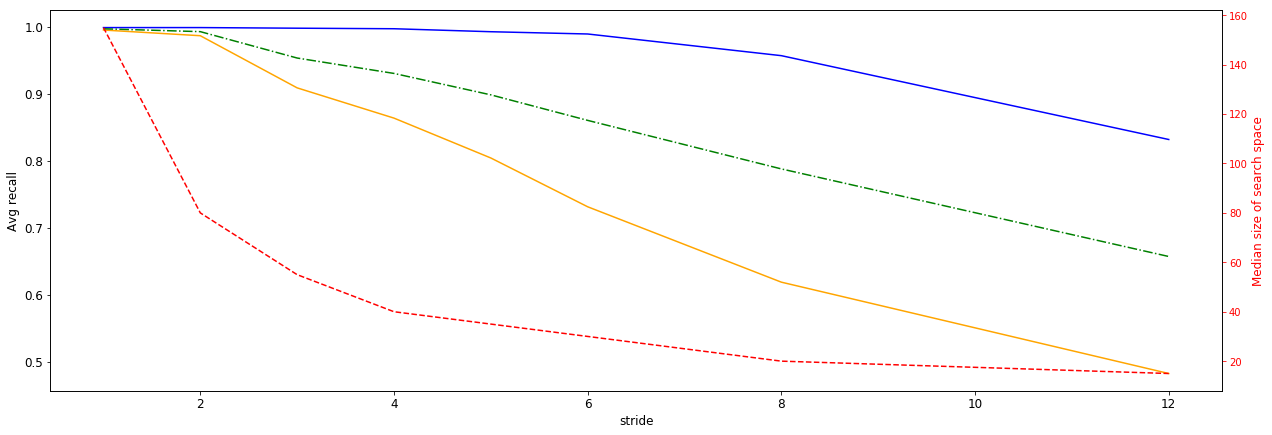

In [4]:
# Variables to edit
min_length = 3
max_length = 80
num_scales = 5
max_stride = min(min_length * num_scales, max_length)
strides = range(0, max_stride)
strides = [2**i for i in range(0, max_stride) if 2**i < max_stride]
strides = [1, 2, 3, 4, 5, 6, 8, 12]

annotation_file = '../data/raw/charades/charades_sta_train.txt'
features_file = '/home/escorciav/datasets/charades/features/resnet101-openimages_5fps_320x240.h5'

import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
font_size = 12
COLOR_2ND_AXIS = 'red' 
IOU_COLORS = ['blue', 'orange', 'green']
iou_thresholds = IOU_THRESHOLDS
assert len(IOU_COLORS) - 1 == len(iou_thresholds)

instances = parse_charades_sta(annotation_file)
videos_df, instances_df = make_annotations_df(instances, features_file)

recalls = []
search_space = []
for stride in tqdm(strides):
    recall_iou, search_space_stats = recall_bound_and_search_space(
        videos_df, instances_df, stride,
        length=min_length, scale=num_scales)
    recalls.append(recall_iou)
    search_space.append(search_space_stats)
search_space = np.vstack(search_space)
recalls = np.vstack(recalls)
recalls = np.column_stack([recalls, recalls.mean(axis=1)])

fig, ax1 = plt.subplots(figsize=(21, 7))
for i, iou in enumerate(iou_thresholds + [None]):
    ls, label, color = '-', f'tIOU={iou}', IOU_COLORS[i]
    if i == len(IOU_COLORS) - 1:
        ls, label = '-.', 'avg tIOU'
    ax1.plot(strides, recalls[:, i], ls=ls,
             color=color, label=label)
ax1.set_xlabel('stride', fontsize=font_size)
ax1.set_ylabel('Avg recall', fontsize=font_size)
ax1.tick_params('y')
ax2 = ax1.twinx()
ax2.plot(strides, search_space[:, 0], ls='--', color=COLOR_2ND_AXIS)
ax2.set_ylabel('Median size of search space',
               color=COLOR_2ND_AXIS, fontsize=font_size)
ax2.tick_params('y', colors='r')
for tick in (ax1.xaxis.get_major_ticks() + 
             ax1.yaxis.get_major_ticks() +
             ax2.yaxis.get_major_ticks()):
    tick.label.set_fontsize(font_size)

To get an idea of the values

In [5]:
info = {'Stride': np.array(strides)}
for i in range(recalls.shape[1]):
    if i > (len(iou_thresholds) - 1):
        iou = f'Avg({iou_thresholds[0]}, {iou_thresholds[-1]})'
    else:
        iou = iou_thresholds[i]
    info[f'R@{iou}'] = recalls[:, i]
for i, label in enumerate(['(median)', '(std)']):
    info[f'Search space size {label}'] = search_space[:, i]
display(pd.DataFrame(info))

,Stride,R@0.5,R@0.7,"R@Avg(0.5, 0.7)",Search space size (median),Search space size (std)
0,1,0.998595,0.994938,0.996766,155.0,47.210689
1,2,0.998595,0.986445,0.992520,80.0,23.631720
2,3,0.997668,0.908581,0.953124,55.0,15.774709
3,4,0.996856,0.863421,0.930138,40.0,11.867081
4,5,0.992403,0.803892,0.898148,35.0,9.517840
5,6,0.989019,0.731048,0.860034,30.0,7.983369
6,8,0.956655,0.618490,0.787572,20.0,6.109018
7,12,0.831499,0.482125,0.656812,15.0,4.079143


Let's make sure that the results look similar in testing a.k.a. there is _NOT_ distribution (training v.s. testing) miss-match.

100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


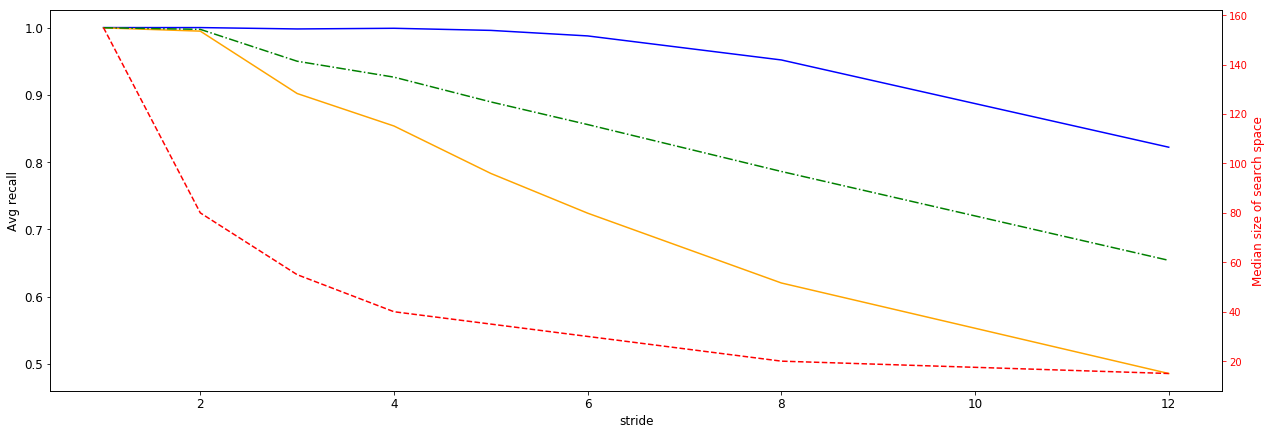

In [6]:
annotation_file = '../data/raw/charades/charades_sta_test.txt'

import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
font_size = 12
COLOR_2ND_AXIS = 'red' 
IOU_COLORS = ['blue', 'orange', 'green']
iou_thresholds = IOU_THRESHOLDS
assert len(IOU_COLORS) - 1 == len(iou_thresholds)

instances = parse_charades_sta(annotation_file)
videos_df, instances_df = make_annotations_df(instances, features_file)

recalls = []
search_space = []
for stride in tqdm(strides):
    recall_iou, search_space_stats = recall_bound_and_search_space(
        videos_df, instances_df, stride,
        length=min_length, scale=num_scales)
    recalls.append(recall_iou)
    search_space.append(search_space_stats)
search_space = np.vstack(search_space)
recalls = np.vstack(recalls)
recalls = np.column_stack([recalls, recalls.mean(axis=1)])

fig, ax1 = plt.subplots(figsize=(21, 7))
for i, iou in enumerate(iou_thresholds + [None]):
    ls, label, color = '-', f'tIOU={iou}', IOU_COLORS[i]
    if i == len(IOU_COLORS) - 1:
        ls, label = '-.', 'avg tIOU'
    ax1.plot(strides, recalls[:, i], ls=ls,
             color=color, label=label)
ax1.set_xlabel('stride', fontsize=font_size)
ax1.set_ylabel('Avg recall', fontsize=font_size)
ax1.tick_params('y')
ax2 = ax1.twinx()
ax2.plot(strides, search_space[:, 0], ls='--', color=COLOR_2ND_AXIS)
ax2.set_ylabel('Median size of search space',
               color=COLOR_2ND_AXIS, fontsize=font_size)
ax2.tick_params('y', colors='r')
for tick in (ax1.xaxis.get_major_ticks() + 
             ax1.yaxis.get_major_ticks() +
             ax2.yaxis.get_major_ticks()):
    tick.label.set_fontsize(font_size)

To get an idea of the values

In [7]:
info = {'Stride': np.array(strides)}
for i in range(recalls.shape[1]):
    if i > (len(iou_thresholds) - 1):
        iou = f'Avg({iou_thresholds[0]}, {iou_thresholds[-1]})'
    else:
        iou = iou_thresholds[i]
    info[f'R@{iou}'] = recalls[:, i]
for i, label in enumerate(['(median)', '(std)']):
    info[f'Search space size {label}'] = search_space[:, i]
display(pd.DataFrame(info))

,Stride,R@0.5,R@0.7,"R@Avg(0.5, 0.7)",Search space size (median),Search space size (std)
0,1,1.000000,0.999563,0.999781,155.0,35.570310
1,2,1.000000,0.994709,0.997354,80.0,17.900878
2,3,0.997951,0.901986,0.949969,55.0,12.013412
3,4,0.998951,0.853677,0.926314,40.0,8.933775
4,5,0.995815,0.783174,0.889495,35.0,7.279285
5,6,0.987594,0.724104,0.855849,30.0,6.245597
6,8,0.951865,0.620346,0.786105,20.0,4.668710
7,12,0.822162,0.485785,0.653974,15.0,3.061400


Based on the previous analysis setting a _stride_ of 3 or 4 sounds like a good point to kick-off experiments.

# 2. Alternatives

The previous analysis studies how to recover as many moments as possible only focus on their duration. This perspective assumes that the search space will consider many candidates. The candicates could come from a proposals method or a sliding window approach.

Another perspective is to define a canonical video length. To scale this perspective to videos of multiple length, we could consider the following strategies:

(i) sliding the model over time (convolution kinda).

(ii) rescaling the temporal dimension (temporal pyramids) similar to how we re-scale images.

  > sounds a bit like a variable chunk-size.

TODO:

- define pertinence.

- define methodology for (i); (ii) and/or (i-ii).

- estimate workload.

## 3. Baseline for single video retrieval

| Model            | R@1,IoU=0.5 | R@1,IoU=0.7 | R@5,IoU=0.5 | R@5,IoU=0.7 |
| :--------------- | ----------: | ----------: | ----------: | ----------: | 
| CTRL (aln)       |   17.69     |    5.91     |    55.54    |     23.79   |
| CTRL (reg-p)     |   19.22     |    6.64     |    57.98    |     25.22   |
| CTRL (reg-np)    |   21.42     |    7.15     |    59.11    |     26.91   |